In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, BatchNormalization, MaxPool2D
from tensorflow.keras import Model

import keras_tuner as kt

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

5


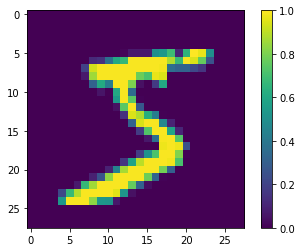

In [4]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

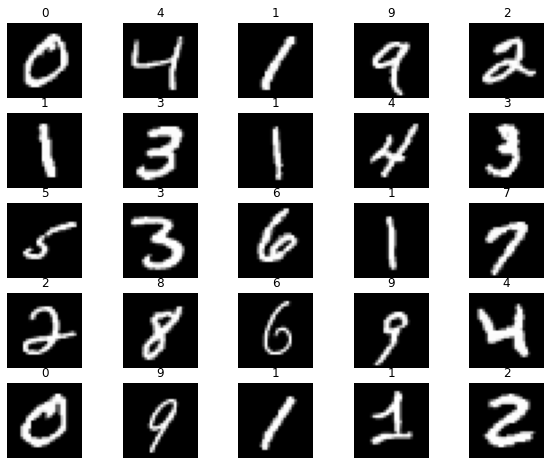

In [5]:
num = 26
imgs = x_train[:num]
lbls = y_train[:num]
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.title(lbls[i])
    plt.axis("off")
    plt.imshow(imgs[i], cmap='gray')
plt.show()

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(64)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [7]:
train_ds, test_ds

(<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>,
 <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>)

In [8]:
def build_model(hp):
    model = tf.keras.Sequential([
        Conv2D(hp.Int('filters_1', 16, 64, step=16), kernel_size=3, activation=hp.Choice('act_1', values=['relu', 'tanh'])),
        Conv2D(hp.Int('filters_2', 32, 128, step=32), kernel_size=3, activation=hp.Choice('act_2', values=['relu', 'tanh'])),
        MaxPool2D(2),
        Flatten(),
        Dense(hp.Int('units', 64, 128, step=64)),
        Dense(10)
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),#learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [9]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='\keras_tuner_logs',
    project_name='mnist_tuner',
    overwrite=True
)

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tb = tf.keras.callbacks.TensorBoard("/keras_tuner_logs/tb_logs")

In [11]:
tuner.search(x_train, y_train, validation_split=0.2, epochs=3, callbacks=[tb])

Trial 10 Complete [00h 00m 48s]
val_accuracy: 0.9800000190734863

Best val_accuracy So Far: 0.9866666793823242
Total elapsed time: 00h 07m 55s
INFO:tensorflow:Oracle triggered exit


In [12]:
%load_ext tensorboard

%tensorboard --logdir /keras_tuner_logs/tb_logs

In [13]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_acc)

NameError: name 'model' is not defined

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
preds = probability_model.predict(test_ds)

In [ ]:
y_test[0], preds[0]

In [ ]:
preds[1].argmax(), y_test[1]
tuple(map(np.argmax, preds))

In [ ]:
preds.shape

In [ ]:
lbls

In [ ]:
num = 9
imgs = x_test[num:num+26]
# lbls = y_test[num:num+26]
# lbls = tuple(map(np.argmax, preds))
lbls = (y_test[num:num+26], tuple(map(np.argmax, preds))[num:num+26])
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
#     plt.title(lbls[i])
    plt.title(f'true={lbls[0][i]}, pred={lbls[1][i]}')
    plt.axis("off")
    cmap_ = 'gray' if lbls[0][i]==lbls[1][i] else 'viridis'
    plt.imshow(imgs[i], cmap=cmap_)
plt.show()

## Custom images

In [ ]:
from PIL import Image
import os

In [ ]:
for i in range(9, 10):
    image = Image.open(os.path.join('mnist_custom', f'{i}.jpg'))
    image.thumbnail((28, 28), Image.ANTIALIAS)
    image.save(os.path.join('mnist_custom', f'{i}.jpg'), 'JPEG')